In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import boxcox
from sklearn.metrics import cohen_kappa_score
import lightgbm as ltb
from sklearn import svm
from sklearn.metrics import cohen_kappa_score

In [32]:
df = pd.read_csv("/kaggle/input/playground-series-s3e5/train.csv")
sample_submission = pd.read_csv("/kaggle/input/playground-series-s3e5/sample_submission.csv")
df_test = pd.read_csv("/kaggle/input/playground-series-s3e5/test.csv")

In [33]:
df.quality.value_counts()

5    839
6    778
7    333
4     55
8     39
3     12
Name: quality, dtype: int64

In [34]:
# from sklearn.cluster import KMeans

# def clustering(df, test_df):
    
#     X = df.copy()
    
#     Test_scaled = test_df.copy()
    
#     num_cluster = 2# cluster数

#     features = ["alcohol", "sulphates", 'density']

#     # Standardize
#     X_scaled = df.loc[:, features]
#     Test_scaled = test_df.loc[:, features]
    
#     X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
#     Test_scaled = (Test_scaled - Test_scaled.mean(axis=0)) / Test_scaled.std(axis=0)
    
#     # YOUR CODE HERE: Fit the KMeans model to X_scaled and create the cluster labels
#     kmeans = KMeans(n_clusters = 5, n_init=10, random_state=0)
# #     kmeans.fit(X_scaled)
#     kmeans.fit(pd.concat([X_scaled, Test_scaled]))
#     df["Cluster"] = kmeans.predict(X_scaled)
#     test_df["Cluster"] = kmeans.predict(Test_scaled)
    
# #     X["Distance"] = kmeans.fit_transform(X_scaled)
#     df["Cluster"] = df["Cluster"].astype('int')
#     test_df["Cluster"] =  test_df["Cluster"].astype('int')
# #     X["Distance"] = X["Distance"].astype('int')
    
#     return df, test_df

# df,df_test = clustering(df,df_test)

In [35]:
# df1 = pd.read_csv("/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv")
# df1 = df1[(df1['quality'] == 3) | (df1['quality'] == 4) | (df1['quality'] == 8)]
# df = pd.concat([df,df1])

In [36]:
#df = pd.concat([df, dff], axis = 0)
df = df.drop("Id", axis = 1)
df_test = df_test.drop("Id", axis = 1)
df = df.drop_duplicates()
df = df.reset_index(drop = True)

In [37]:
train_data = df

In [38]:
# SAMPLES=500
# RND = 12345
# frames = [train_data[train_data['quality'] == 8].sample(n=120, random_state=RND, replace=True),
#           train_data[train_data['quality'] == 7].sample(n=333, random_state=RND, replace=True),
#           train_data[train_data['quality'] == 6].sample(n=778, random_state=RND, replace=True),
#           train_data[train_data['quality'] == 5].sample(n=839, random_state=RND, replace=True),
#           train_data[train_data['quality'] == 4].sample(n=165, random_state=RND, replace=True),
#           train_data[train_data['quality'] == 3].sample(n=36, random_state=RND, replace=True)]

# train_data = pd.concat(frames)

In [39]:
df = train_data

In [40]:
df = df.reset_index(drop = True)

<AxesSubplot:xlabel='quality', ylabel='count'>

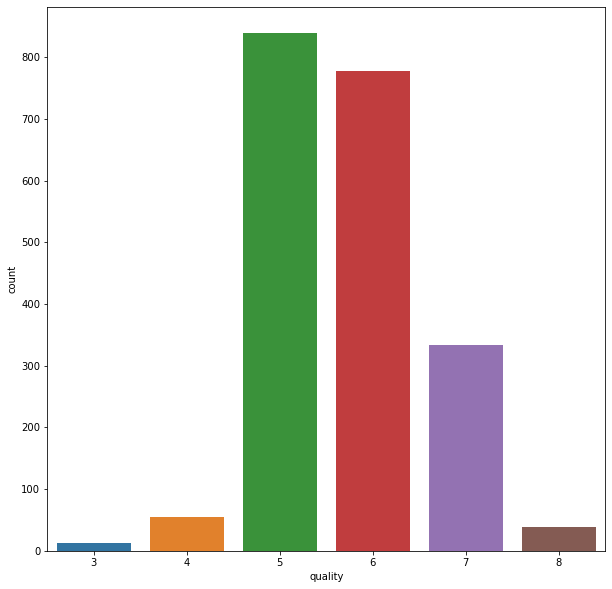

In [41]:
plt.figure(figsize=(10,10))
sns.countplot(data = df, x = "quality")

In [42]:
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,8.0,0.50,0.39,2.20,0.073,30.0,39.0,0.99572,3.33,0.77,12.1,6
1,9.3,0.30,0.73,2.30,0.092,30.0,67.0,0.99854,3.32,0.67,12.8,6
2,7.1,0.51,0.03,2.10,0.059,3.0,12.0,0.99660,3.52,0.73,11.3,7
3,8.1,0.87,0.22,2.60,0.084,11.0,65.0,0.99730,3.20,0.53,9.8,5
4,8.5,0.36,0.30,2.30,0.079,10.0,45.0,0.99444,3.20,1.36,9.5,6
...,...,...,...,...,...,...,...,...,...,...,...,...
2051,6.6,0.31,0.13,2.00,0.056,29.0,42.0,0.99388,3.52,0.87,12.0,7
2052,9.7,0.59,0.21,1.80,0.079,27.0,65.0,0.99745,3.14,0.58,9.4,5
2053,7.7,0.43,0.42,1.70,0.071,19.0,37.0,0.99258,3.32,0.77,12.5,8
2054,9.1,0.50,0.00,1.75,0.058,5.0,13.0,0.99670,3.22,0.42,9.5,5


In [43]:
def feature_engineering(df):
    quality_mapping = {3:0, 4:1, 5:2, 6:3, 7:4, 8:5}
    df.loc[:, "quality"] = df.quality.map(quality_mapping)
    
#     df["total sulfur dioxide"] = df["total sulfur dioxide"].apply(lambda x : np.log(1 + x))
#     df["free sulfur dioxide"] = df["free sulfur dioxide"].apply(lambda x : np.log(1 + x))
#     df["citric acid"] = df["citric acid"].apply(lambda x : np.log(1 + x))
#     df["alcohol"] = df["alcohol"].apply(lambda x : np.log(1 + x))
    
    
    df["total sulfur dioxide - free sulfur dioxide"] = df["total sulfur dioxide"] - df["free sulfur dioxide"]
    df["residual sugar * chlorides"] = df["residual sugar"] * df["chlorides"]
    df["fixed acidity + volatile acidity"] = df["fixed acidity"] + df["volatile acidity"]
    df["residual sugar * density"] = df["residual sugar"] * df["density"]
    
    df['total_acid'] = df['fixed acidity'] + df['volatile acidity'] + df['citric acid']
    df['acid/density'] = df['total_acid']  / df['density']
    df['alcohol_density'] = df['alcohol']  * df['density']
    df['sulphate/density'] = df['sulphates']  / df['density']
    df['sulphates/acid'] = df['sulphates'] / df['volatile acidity']
    df['sulphates/chlorides'] = df['sulphates'] / df['chlorides']
    df['sulphates*alcohol'] = df['sulphates'] / df['alcohol']
    
    
    df["citric acid"] = df["citric acid"].apply(lambda x : np.log(1 + x))

    for i in ["total sulfur dioxide","free sulfur dioxide", "alcohol"]:
        bcx_target, lam = boxcox(df[i])
        df[i] = bcx_target
        
    pf = preprocessing.PolynomialFeatures(degree = 2, interaction_only = True, include_bias = False)
    poly_feats = pf.fit_transform(df.drop(["quality"], axis=1))
    num_feats = poly_feats.shape[1]
    df_tranformed = pd.DataFrame(poly_feats, 
                            columns = [f"f_{i}" for i in range(1, num_feats + 1)])
    df = pd.concat([df_tranformed, df.quality],axis = 1)
    
    for i in df.columns:
        if i != "quality":
            df["{}_bined".format(i)] = pd.cut(df[i], bins = 5, labels = False)
    
    
  
    
    return df

In [44]:
def make_fold(df, fold):
    df["kfold"] = -1
    df.sample(frac=1).reset_index(drop = True)
    y = df.quality.values
    kf = model_selection.StratifiedKFold(n_splits = fold)
    for f, (t_,v_) in enumerate(kf.split(X = df, y = y)):
        df.loc[v_, 'kfold'] = f
    return df

In [45]:
df = feature_engineering(df)
df = make_fold(df, 10)

In [46]:
df_test["quality"] = 0
df_test = feature_engineering(df_test)

In [47]:
from sklearn.feature_selection import VarianceThreshold

def VarianceThreshould(df, df_test):
   
    data = df.drop(["kfold", "quality"], axis = 1)
    var_thresh = VarianceThreshold(threshold = 0.01)
    var_thresh.fit(data)
    a = var_thresh.get_support()
    data = data.loc[:, a]
    df = pd.concat([data,df[["kfold", "quality"]]], axis = 1)
    df_te = df_test.drop(["quality"], axis = 1)
    df_te = df_te.loc[:, a]
    df_test = pd.concat([df_te,df_test[["quality"]]], axis = 1)
    
    return df, df_test

In [48]:
# df, df_test = VarianceThreshould(df, df_test)

In [49]:
from sklearn.feature_selection import RFE

def RFEE(df, df_test):
    cols = list(df.columns)
    cols.remove('quality')
    cols.remove('kfold')
    X = df[cols]
    y = df.quality
    model = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs')
    rfe = RFE(estimator = model, verbose = 10,n_features_to_select = 210)
    rfe.fit(X,y)
    a = rfe.support_
    df = pd.concat([X.loc[:, a],df[["quality", "kfold"]]], axis = 1)
    df_test.drop("quality", axis = 1)
    t = df_test.drop("quality", axis = 1)
    df_test = pd.concat([t.loc[:, a], df_test[["quality"]]], axis = 1)
    
    return df, df_test

In [50]:
cols = list(df.columns)
cols.remove('quality')
cols.remove('kfold')

In [51]:
#inference

fold_train = 0
fold_test = 0
fold = 5
test_list = []
for i in tqdm(range(fold)):
    df_train = df[df['kfold'] != i]
    model = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', penalty = 'l2', C = 0.2)
    model.fit(df_train[cols], df_train.quality)  
# #     model = RandomForestClassifier(max_depth = 11, n_estimators=300, criterion = 'entropy')
# #     model.fit(df_train[cols], df_train.quality)
#     model = svm.SVC(C = 100, class_weight = None)
#     model.fit(df_train[cols], df_train.quality)
    test_predictions = model.predict(df_test[cols]) 
    test_list.append(test_predictions)

test_array = np.array(test_list)
pred = [*map(lambda x : np.argmax(np.bincount(x)), test_array.T)]

100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


test_list

In [52]:
test_array

array([[3, 2, 3, ..., 2, 2, 2],
       [2, 2, 3, ..., 2, 2, 2],
       [3, 2, 3, ..., 2, 2, 2],
       [3, 2, 3, ..., 2, 2, 2],
       [3, 2, 3, ..., 2, 2, 2]])

In [53]:
# #inference2

# fold_train = 0
# fold_test = 0
# fold = 1
# test_list = []
# for i in tqdm(range(fold)):
#     #df_train = df[df['kfold'] != i]
#     df_train = df
#     model = ltb.LGBMClassifier()
#     model.fit(df_train[cols], df_train.quality)
#     test_predictions = model.predict(df_test[cols]) 
#     test_list.append(test_predictions)

# pred = test_predictions
# #test_array = np.array(test_list)
# #pred = [*map(lambda x : np.argmax(np.bincount(x)), test_array.T)]

In [54]:
df.columns

Index(['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10',
       ...
       'f_245_bined', 'f_246_bined', 'f_247_bined', 'f_248_bined',
       'f_249_bined', 'f_250_bined', 'f_251_bined', 'f_252_bined',
       'f_253_bined', 'kfold'],
      dtype='object', length=508)

In [55]:
sample_submission

,Id,quality
0,2056,5
1,2057,5
2,2058,5
3,2059,5
4,2060,5
...,...,...
1367,3423,5
1368,3424,5
1369,3425,5
1370,3426,5


In [56]:
sample_submission.loc[:, "quality"] = pred
quality_mapping = {0:3, 1:4, 2:5, 3:6, 4:7, 5:8}
sample_submission.loc[:, "quality"] = sample_submission.quality.map(quality_mapping)
sample_submission.to_csv("/kaggle/working/sample_submission13.csv",index=False)

<AxesSubplot:xlabel='quality', ylabel='count'>

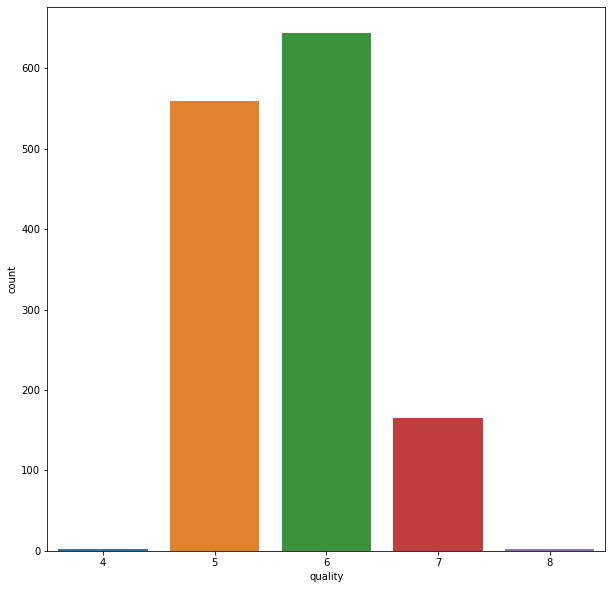

In [57]:
plt.figure(figsize = (10,10))
sns.countplot(data = sample_submission, x = 'quality')